In [13]:
import os
import re
import random
from argparse import Namespace

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
import torchaudio
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

import sacrebleu
import sentencepiece

from fairseq import utils
from fairseq.data import Dictionary, data_utils as fairseq_data_utils
from fairseq.models.speech_to_text.xstnet import XSTNet
from fairseq.data.audio.speech_text_triple_align_dataset import (
    SpeechTextTripleAlignDataset
)
from fairseq.criterions.multitask_crossentropy_with_contrastive_token_with_extra_mt import MultiTaskCrossEntropyWithContrastiveTokenWithExtraMT
from fairseq.data.audio.speech_to_text_dataset import get_features_or_waveform, _collate_frames
from ConST.prepare_data.data_utils import load_df_from_tsv, save_df_to_tsv
from fairseq.checkpoint_utils import load_checkpoint_to_cpu, save_state, torch_persistent_save

In [2]:
device = 'cuda:6'

# Load Checkpoint

In [5]:
args = Namespace()
task = Namespace()

args.w2v2_model_path = '/mnt/data/siqiouyang/runs/mST/pretrained/wav2vec_small.pt'

args.max_audio_positions = 600000
args.max_source_positions = 1024
args.max_target_positions = 1024
args.max_audio_tokens = 1000000
args.max_text_tokens = 2000
args.max_tokens = 1000000
args.max_tokens_valid = 2000000

tgt_dict = Dictionary.load('/mnt/data/siqiouyang/datasets/must-c-v1.0/spm_unigram10000_st_de.txt')
task.target_dictionary = tgt_dict

model = XSTNet.build_model(args, task)

In [6]:
tag = 'main_ende_token'

In [7]:
ckpt_path = '/mnt/data/siqiouyang/runs/ConST/{}/checkpoint_best.pt'.format(tag)
ckpt = load_checkpoint_to_cpu(ckpt_path)

In [8]:
model.load_state_dict(ckpt['model'])
model = model.to(device)

# Compute Gradient

In [9]:
spm = sentencepiece.SentencePieceProcessor()
spm.Load('/mnt/data/siqiouyang/datasets/must-c-v1.0/spm_unigram10000_st_de.model')

True

In [75]:
df = load_df_from_tsv('/mnt/data/siqiouyang/datasets/must-c-v1.0/tst-COMMON_st_de.tsv')

In [76]:
loss_fn = MultiTaskCrossEntropyWithContrastiveTokenWithExtraMT(task, False, 0., 1, )

In [77]:
def gather_gradient(model):
    all_grad = []
    for param in model.encoder.parameters():
        if param.requires_grad and param.grad is not None:
            all_grad.append(param.grad.flatten())
    all_grad = th.cat(all_grad, dim=0)
    return all_grad

In [81]:
def compute_sim(idx):
    align_path = '/mnt/data/siqiouyang/datasets/must-c-v1.0/en-de/data/tst-COMMON/align/{}.pt'.format(df['id'][idx])
    if os.path.exists(align_path):
        audio_path = os.path.join('/mnt/data/siqiouyang/datasets/must-c-v1.0', df['audio'][idx])
        audio = get_features_or_waveform(audio_path, need_waveform=True).to(device)
        
        tokenized =  " ".join(spm.EncodeAsPieces(df['src_text'][idx]))
        src_text = tgt_dict.encode_line(
            tokenized, add_if_not_exist=False, append_eos=True
        ).long()
        lang_tag = SpeechTextTripleAlignDataset.LANG_TAG_TEMPLATE.format(df['src_lang'][idx])
        lang_tag_idx = tgt_dict.index(lang_tag)
        src_text = th.cat((th.LongTensor([lang_tag_idx]), src_text), 0).unsqueeze(0).to(device)

        n_frame = th.LongTensor([audio.size(1)]).to(device)
        src_length = th.LongTensor([src_text.size(1)])

        tokenized = " ".join(spm.EncodeAsPieces(df['tgt_text'][idx]))
        tgt_text = tgt_dict.encode_line(
            tokenized, add_if_not_exist=False, append_eos=True
        ).long()
        lang_tag = SpeechTextTripleAlignDataset.LANG_TAG_TEMPLATE.format(df['tgt_lang'][idx])
        lang_tag_idx = tgt_dict.index(lang_tag)
        tgt_text = th.cat((th.LongTensor([lang_tag_idx]), tgt_text), 0)

        target = fairseq_data_utils.collate_tokens(
            [tgt_text],
            tgt_dict.pad(),
            tgt_dict.eos(),
            left_pad=False,
            move_eos_to_beginning=False,
        ).to(device)
        prev_output_target_tokens = fairseq_data_utils.collate_tokens(
            [tgt_text],
            tgt_dict.pad(),
            tgt_dict.eos(),
            left_pad=False,
            move_eos_to_beginning=True,
        ).to(device)

        sample = {
            "net_input": {
                "src_tokens": audio,
                "src_lengths": n_frame,
                "prev_output_tokens": prev_output_target_tokens
            },
            "target": target
        }

        model.zero_grad()
        loss, nll_loss, _ = loss_fn.compute_loss_st(model, sample, reduce=True)
        nll_loss.backward()

        st_grad = gather_gradient(model)

        model.zero_grad()

        st_encoder_out = model.encoder(audio.to(device), n_frame.to(device))
        st_x = st_encoder_out.encoder_out.squeeze(1)
        mt_encoder_out = model.encoder(src_text.to(device), src_length.to(device), is_text_input=True)
        mt_x = mt_encoder_out.encoder_out.squeeze(1)

        seg, itv = th.load(align_path)
        seg = [(s[0] + 1, s[1] + 1) for s in seg]
        itv = (itv * st_encoder_out.encoder_padding_mask.size(1)).astype(int)
        st_f = []
        mt_f = []
        for (t_l, t_r), (s_l, s_r) in zip(seg, itv):
            st_f.append(st_x[s_l : s_r + 1].mean(dim=0))
            mt_f.append(mt_x[t_l : t_r + 1].mean(dim=0))
        st_f = th.stack(st_f, dim=0)
        mt_f = th.stack(mt_f, dim=0)

        logits = F.cosine_similarity(
            st_f.unsqueeze(1),
            mt_f.unsqueeze(0),
            dim=-1
        ) / 0.05

        label = th.arange(st_f.size(0)).to(logits.device)
        loss = F.cross_entropy(logits, label, reduction='sum')
        loss.backward()

        token_cst_grad = gather_gradient(model)
        token_cos_sim = (st_grad * token_cst_grad).sum() / st_grad.norm() / token_cst_grad.norm()

        # model.zero_grad()

        # st_encoder_out = model.encoder(audio.to(device), n_frame.to(device))
        # st_x = st_encoder_out.encoder_out
        # mt_encoder_out = model.encoder(src_text.to(device), src_length.to(device), is_text_input=True)
        # mt_x = mt_encoder_out.encoder_out

        # st_encoder_padding_mask = st_encoder_out.encoder_padding_mask
        # st_encoder_out = st_x.transpose(0, 1) # T x B x hid -> B x T x hid
        # st_encoder_padding_mask = (~st_encoder_padding_mask).float()
        # st_seq_hidden = (st_encoder_out * st_encoder_padding_mask.unsqueeze(-1)).sum(dim=1) / st_encoder_padding_mask.sum(dim=1).unsqueeze(-1)

        # mt_encoder_padding_mask = mt_encoder_out.encoder_padding_mask
        # mt_encoder_out = mt_x.transpose(0, 1) # T x B x hid -> B x T x hid
        # mt_encoder_padding_mask = (~mt_encoder_padding_mask).float()
        # mt_seq_hidden = (mt_encoder_out * mt_encoder_padding_mask.unsqueeze(-1)).sum(dim=1) / mt_encoder_padding_mask.sum(dim=1).unsqueeze(-1)

        # logits = F.cosine_similarity(st_seq_hidden.expand((1, 1, 512)), mt_seq_hidden.expand((1, 1, 512)).transpose(0, 1), dim=-1) / 0.02
        # loss = -th.nn.LogSoftmax(0)(logits).diag()
        # loss.backward()

        # sent_cst_grad = gather_gradient(model)
        # sent_cos_sim = (st_grad * sent_cst_grad).sum() / st_grad.norm() / sent_cst_grad.norm()
        return token_cos_sim
    else:
        return None

In [82]:
token_cos_sims = []
for idx in tqdm(range(len(df))):
    token_cos_sims.append(compute_sim(idx))

  0%|          | 0/2587 [00:00<?, ?it/s]

In [85]:
token_cos_sims = [s.item() for s in token_cos_sims if s is not None]

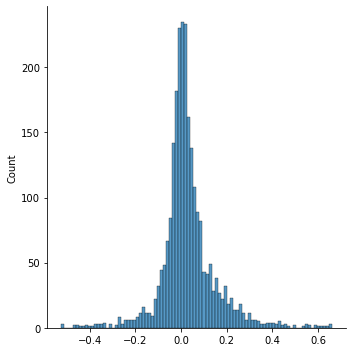

In [86]:
sns.displot(token_cos_sims)